In [1]:
import sys
import numpy as np 
import multiprocessing
import bluepyopt as bpop
from bluepyopt.parameters import Parameter
from time import time as wall_time
import os
import brian2 as b2
sys.path.append('C:/Users/Nishant Joshi/Documents/Siamese_net/Brian2_GLIF_AllenSDK')
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from GLIF_1 import * 
from GLIF_2 import run_brian_sim as GLIF2_sim  
from GLIF_2 import add_parameter_units as add_parameter_units_g2  
from GLIF_2 import parameters_from_list as parameters_from_list_g2  

from GLIF_3 import run_brian_sim as GLIF3_sim  
from GLIF_3 import add_parameter_units as add_parameter_units_g3  
from GLIF_3 import parameters_from_list as parameters_from_list_g3  

from GLIF_5 import run_brian_sim as GLIF5_sim  
from GLIF_5 import add_parameter_units as add_parameter_units_g5  
from GLIF_5 import parameters_from_list as parameters_from_list_g5  


from utils import *
import matplotlib.pyplot as plt

parameters = {'El':{'value':-0.0788450355529785,'bounds':[-0.08,-0.06],'frozen':[]},
              'C':{'value':5.872100585460524e-11,'bounds':[4e-11, 6e-11],'frozen':[]},
              'G':{'value':18e-10,'bounds':[10e-11,25e-10],'frozen':[]},
              't_ref':{'value':0.001,'bounds':[0.0001,0.1],'frozen':[]},
              'Th_inf':{'value':-0.03185670047392382,'bounds':[-0.1, -0.01],'frozen':[]},
              'V_reset':{'value':-0.1,'bounds':[-0.12,-0.08],'frozen':[]}}





INFO       Cache size for target 'cython': 5188 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\Nishant Joshi\.cython\brian_extensions' directory. [brian2]


In [2]:
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I']
V_data = data['V']
spikes_data = data['spikes']   


In [3]:
class EphysData:

    def __init__(self,I,V,spikes,dt,start,stop):
        self.I = I[int(start/dt):int(stop/dt)]
        self.V = V[int(start/dt):int(stop/dt)]
        self.spikes = spikes[(spikes>=int(start/dt))&(spikes<=int(stop/dt))]
        self.spikes = self.spikes
        self.dt = dt
        self.spiketimes = self.spikes*dt 
        self.T = stop-start #(ms)
    def getSpikeTimes(self):
        return self.spiketimes
    def getBinarySpikeTrain(self):
        b_spikes = np.zeros(len(self.V))
        b_spikes[self.spikes] =1
        return b_spikes
class Parameter:

    def __init__(self):
        None
    
    def getSpikeTimes(self):
        return None

experiment = EphysData(I_data,V_data,spikes_data,1/20,0,10*1000)
experiment_test = EphysData(I_data,V_data,spikes_data,1/20,0*1000,200*1000)
parameter_glif = Parameter


In [4]:
# Run the simulation for the best parameters

params_init = {'El':-52.249/1000,
               'C':0.028e-9,
               'G':0.008374e-6,
               'Th_inf':-50/1000,
               't_ref':4/1000,
               'V_reset':-55.354/1000}

params_init = add_parameter_units(params_init)

brian2.start_scope()

t, fitted_voltage,spks = run_brian_sim(stim = experiment.I*b2.pA,
                                param_dict=params_init,
                                init_values={'V_init':params_init['El']}, 
                                dt=1/20000*b2.second, )



running  10704
finished  10704


In [7]:
np.array(spks.spike_trains()[0])
experiment.spiketimes[experiment.spiketimes<10*1000]/1000
t= np.linspace(0,len(experiment.V)/20,len(experiment.V))
def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,np.array(spks.spike_trains()[0])*1000,experiment.dt,type='nan')

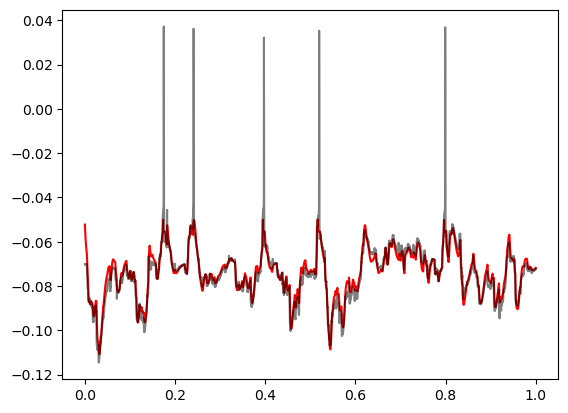

In [12]:
p_time = 1
# plt.scatter(t[:p_time*20000]/1000,data_spks[:p_time*20000]*55 ,c='black',s=5)
# plt.scatter(t[:p_time*20000]/1000,model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t[:p_time*20000]/1000,fitted_voltage[:p_time*20000],c='red')
plt.plot(t[:p_time*20000]/1000,experiment.V[:p_time*20000]/1000,alpha=0.5,c='black')


In [17]:
np.sqrt(np.mean((fitted_voltage-experiment.V/1000)**2))

0.004323858135954194

In [9]:

def get_gamma_factor(model, data, delta, time, dt, rate_correction=True):
    """
    Calculate gamma factor between model and target spike trains,
    with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    Returns
    -------
    float
        An error based on the Gamma factor. If ``rate_correction`` is used,
        then the returned error is :math:`1 + 2\frac{\lvert r_\mathrm{data} - r_\mathrm{model}\rvert}{r_\mathrm{data}} - \Gamma`
        (with :math:`r_\mathrm{data}` and :math:`r_\mathrm{model}` being the
        firing rates in the data/model, and :math:`\Gamma` the coincidence
        factor). Without ``rate_correction``, the error is
        :math:`1 - \Gamma`. Note that the coincidence factor :math:`\Gamma`
        has a maximum value of 1 (when the two spike trains are exactly
        identical) and a value of 0 if there are only as many coincidences
        as expected from two homogeneous Poisson processes of the same rate.
        It can also take negative values if there are fewer coincidences
        than expected by chance.
    """
    model = np.array(model)
    data = np.array(data)

    model = np.array(model / dt, dtype=np.int32)
    data = np.array(data / dt, dtype=np.int32)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * data_rate * delta * model_length  #2*v2*p*N1
    norm = .5*(1 - 2 * max(data_rate,model_rate) * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    return gamma
    # return np.clip(rate_term - gamma, 0, np.inf)


# get_gamma_factor(model_spike_times,data_spike_times,5,100,1/20)

WARNING    <>:2: SyntaxWarning: invalid escape sequence '\l'
 [py.warnings]
WARNING    <>:2: SyntaxWarning: invalid escape sequence '\l'
 [py.warnings]
WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_16108\2867258582.py:2: SyntaxWarning: invalid escape sequence '\l'
  """
 [py.warnings]


## LIF2

In [66]:
def rms(val1,val2):
    return [np.sqrt(np.mean((val1-val2)**2))]

# 'El' :-0.054107081692151136,    
# 'C':2.856582627363217e-11, 
# 'G':8.373039461168674e-09, 
# 't_ref':-0.04527416056513923, 
# 'Th_inf':0.0045239157501389335, 
# 'a_r': 0.3724989447937439, 
# 'b_r':-0.07779929218140384, 
# 'a_s':-0.01040850002476415,
# 'b_s': 89.05937992688483   


list_params =[-0.055386837477058436, 2.8528761353768743e-11, 8.372291140933922e-09, -0.045767902388055545, 0.004561947656121529, 0.8189493539349575, -0.06896992868110527, -0.010083883409803623, 86.03637983499952]

params = parameters_from_list_g2(list_params)

params_init = {'El':-0.052249,
               'C':28e-12,
               'G':8.3745e-9,
               'Th_inf':-0.045767902388055545,
               't_ref':0.004,
               'V_reset':-0.055354,
               'Th_s':-0.04,
               'a_r':  0.3724989447937439,         
               'b_r': -0.07779929218140384,
               'a_s': -0.01040850002476415,
               'b_s':  89.05937992688483   ,       
               } 
brian2.start_scope()
 
params_init_with_units = add_parameter_units_g2(params_init)

t, fitted_voltage,th_s, spks = GLIF2_sim(stim = experiment.I*b2.pA,
                                    param_dict=params_init_with_units,
                                init_values={'V_init':params_init['El'],'Th_s':params_init['Th_s']}, 
                                dt=1/20000*b2.second, )




running  1556
finished  1556


In [67]:
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
print(rms(fitted_voltage,experiment.V/1000))
print(get_gamma_factor(model_spike_times,data_spike_times,4,1000,1/20))


[0.006386324924278486]
0.5355098579605682


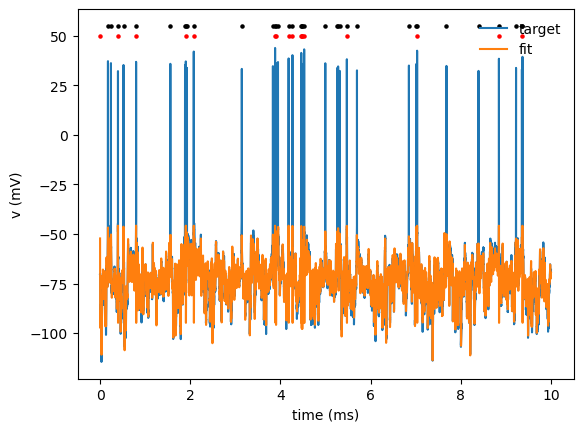

In [70]:
p_time = 10
plt.scatter(t[:p_time*20000],data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000],model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t, experiment.V, label='target')
plt.plot(t, fitted_voltage*1000, label='fit')
plt.legend(frameon=False); 
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.show()


## GLIF3

In [73]:
def rms(val1,val2):
    return [np.sqrt(np.mean((val1-val2)**2))]


params_init = {'V_init':-0.052249,
               'I_0':10e-12,
               'I_1':10e-12,
                }

list_params = [-0.05251569477710258, 2.7004212106702223e-11, 8.346770297273584e-09, -0.04767937964296501, 0.00402376079399319, -0.05047090142809699, 9.909019765855576e-12, 76.85296987185038, 0.14919372715935453, 4.201884209678848e-12, 84.17400584078261, 3.0413037833924417]
params = parameters_from_list_g3(list_params)
print(params)
# params = {'El':-0.052249,
#             'C':28e-12,
#             'G':8.3745e-9,
#             'Th_inf':-0.050,
#             't_ref':0.004,
#             'V_reset':-0.055354,
#             'A_0':10e-12,                   #8.109218551851033e-12,
#             'k_0':1,                        #55.759328790147414,             
#             'R_0':0.01,                     #0.54194969944564021,
#             'A_1':10e-12,                   #10e-12,
#             'k_1':52.738218909419864,       #85.61965883677301,         
#             'R_1':0.05,}                    #3.663699770618375} 

brian2.start_scope()
 
params_init_with_units = add_parameter_units_g3(params)

t, fitted_voltage, I_0, I_1,spks = GLIF3_sim(stim = experiment.I*b2.pA,
                                            param_dict=params_init_with_units,
                                            init_values={'V_init':params['El'],
                                                        'I_0':params_init['I_0'],
                                                        'I_1':params_init['I_1']}, 
                                            dt=1/20000*b2.second, )


{'El': -0.05251569477710258, 'C': 2.7004212106702223e-11, 'G': 8.346770297273584e-09, 'Th_inf': -0.04767937964296501, 't_ref': 0.00402376079399319, 'V_reset': -0.05047090142809699, 'A_0': 9.909019765855576e-12, 'k_0': 76.85296987185038, 'R_0': 0.14919372715935453, 'A_1': 4.201884209678848e-12, 'k_1': 84.17400584078261, 'R_1': 3.0413037833924417}
running  1556


In [59]:

data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
print(rms(fitted_voltage,experiment.V/1000))
print(get_gamma_factor(model_spike_times,data_spike_times,4,1000,1/20))


[0.0042185636505453206]
0.6354761466200037


In [60]:
def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,np.array(spks.spike_trains()[0])*1000,experiment.dt,type='nan')

WARNING    c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


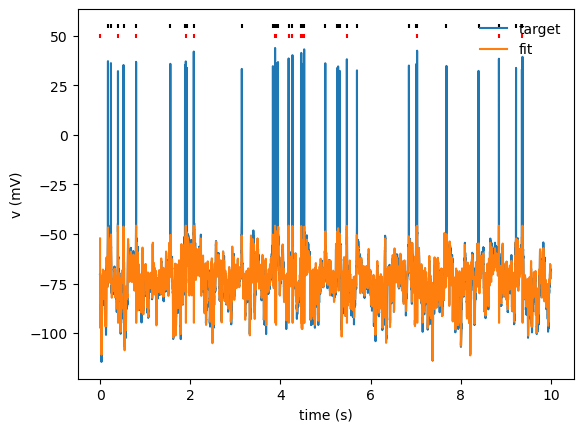

In [71]:
p_time = 10
plt.scatter(t[:p_time*20000],data_spks[:p_time*20000]*55 ,c='black',s=5,marker='|')
plt.scatter(t[:p_time*20000],model_spks[:p_time*20000]*50,c='red'  ,s=5,marker='|')

plt.plot(t, experiment.V, label='target')
plt.plot(t, fitted_voltage*1000, label='fit')
plt.legend(frameon=False); 
plt.xlabel('time (s)')
plt.ylabel('v (mV)')
plt.show()

## GLIF 5

In [48]:
def rms(val1,val2):
    return [np.sqrt(np.mean((val1-val2)**2))]


params = {'El':     -0.052249,
          'C':       28e-12,
          'G':       8.3745e-9,
          'Th_inf': -0.050,
          't_ref':   0.004,
          'V_reset':-0.055354,
          'a_r':     0.3724989447937439,     #none
          'b_r':    -0.07779929218140384,    #volt
          'a_s':    -0.01040850002476415,    #volt
          'b_s':     89.05937992688483,      #hertz
          'a_v':     0.02                ,    #hertz
          'b_v':     0.02                ,    #hertz
          'A_0':     9.909019765855576e-12,  #amp
          'k_0':     76.85296987185038,      #hertz        
          'R_0':     0.14919372715935453,    #none
          'A_1':     4.201884209678848e-12,  #amp
          'k_1':     84.17400584078261,      #hertz  
          'R_1':     3.0413037833924417}     #none


params_init = {'V_init':params['El'],
               'I_0':1e-12,
               'I_1':1e-12,
               'Th_s': -20/1000,
               'Th_v': -20/1000}


# params = parameters_from_list_g5(list_params)
brian2.start_scope()
 
params_init_with_units = add_parameter_units_g5(params)

t, fitted_voltage, Th_s, Th_v, I_0, I_1,spks = GLIF5_sim(stim = experiment.I*b2.pA,
                                            param_dict=params_init_with_units,
                                            init_values={'V_init':params['El'],
                                                         'I_0':   params_init['I_0'],
                                                         'I_1':   params_init['I_1'],
                                                         'Th_s':  params_init['Th_s'],
                                                         'Th_v':  params_init['Th_v']}, 
                                            dt=1/20000*b2.second, )


running  16108


In [49]:

data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
print(rms(fitted_voltage,experiment.V/1000))
print(get_gamma_factor(model_spike_times,data_spike_times,4,1000,1/20))


[0.004175089146570884]
0.0


In [44]:
def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes
data_spike_times = experiment.spiketimes
model_spike_times = np.array(spks.spike_trains()[0])*1000
data_spks = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')
model_spks = getBinarySpikeTrain(fitted_voltage,np.array(spks.spike_trains()[0])*1000,experiment.dt,type='nan')

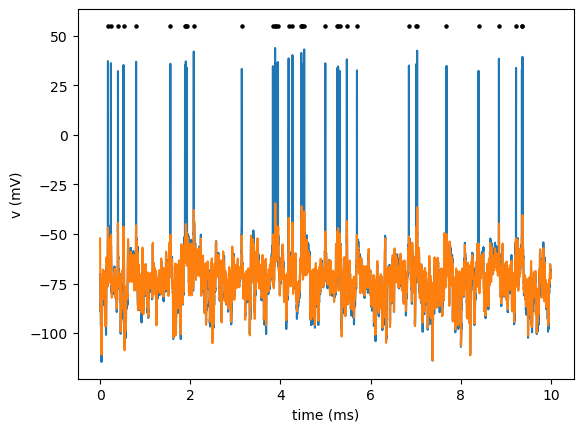

In [46]:
p_time = 10
plt.scatter(t[:p_time*20000],data_spks[:p_time*20000]*55 ,c='black',s=5)
plt.scatter(t[:p_time*20000],model_spks[:p_time*20000]*50,c='red'  ,s=5)

plt.plot(t, experiment.V, label='target')
plt.plot(t, fitted_voltage*1000, label='fit')
# plt.legend(frameon=False); 
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.show()